# Loading libraries and our csv file

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split as sk_train_test
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
from surprise import SVD, KNNBasic, KNNWithMeans, CoClustering, SVDpp, NMF, KNNWithZScore,SlopeOne
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV

df = pd.read_csv('../input/video-game-recommendation-csv/Game_ratings_PS4.csv',index_col=0)

In [2]:
#checking if our data loaded correctly
df.head()

,Users,Game_name,user_rating
0,/user/OVLange,Red Dead Redemption 2,10
1,/user/MisterLupus,Red Dead Redemption 2,7
2,/user/thehoneyman,Red Dead Redemption 2,7
3,/user/Yozakura,Red Dead Redemption 2,6
4,/user/colinsmall34,Red Dead Redemption 2,7


Attributes:

Users : Every user identified with a unique id

Game_name : Every game identified with a unique id

user_rating : Rating of the corresponding game by the corresponding user

# EDA of the data

In [3]:
#code to only fetch users who have 5 and above ratings.
game_groupby_users_Ratings = df.groupby('Users')['user_rating']
game_groupby_users_Ratings = pd.DataFrame(game_groupby_users_Ratings.count())

In [4]:
user_list_min50_ratings = game_groupby_users_Ratings[game_groupby_users_Ratings['user_rating'] > 4].index
df_games =  df[df['Users'].isin(user_list_min50_ratings)]

In [5]:
#checking the dimension of our data.
print('The total number of rows :', df_games.shape[0])
print('The total number of columns :', df_games.shape[1])

The total number of rows : 58384
The total number of columns : 3


1. Data type of each attribute

In [6]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58384 entries, 4 to 258562
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Users        58384 non-null  object
 1   Game_name    58384 non-null  object
 2   user_rating  58384 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


2. Checking for missing values

In [7]:
#printing missing values
display(df_games.isna().sum().sort_values())

Users          0
Game_name      0
user_rating    0
dtype: int64

Seems our data does not have any missing values.

3. Five point summary of numerical attributes

In [8]:
#5 point summary
display(df_games[['user_rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
user_rating,58384.0,7.11659,2.97285,0.0,6.0,8.0,9.0,10.0


As we can see from the above output, seems that the game reviews we scraped has a mean of 7.11 . It shows our data has a good combination of both positive and negative reviews.

4. Unique Users and Products Count

In [9]:
print('Total unique users in the dataset', df_games['Users'].nunique())
print('Total unique products in the dataset', df_games['Game_name'].nunique())

Total unique users in the dataset 5482
Total unique products in the dataset 2034


# Data Visualization and Analysis

1. Game Rating Distribution

<AxesSubplot:xlabel='user_rating', ylabel='Density'>

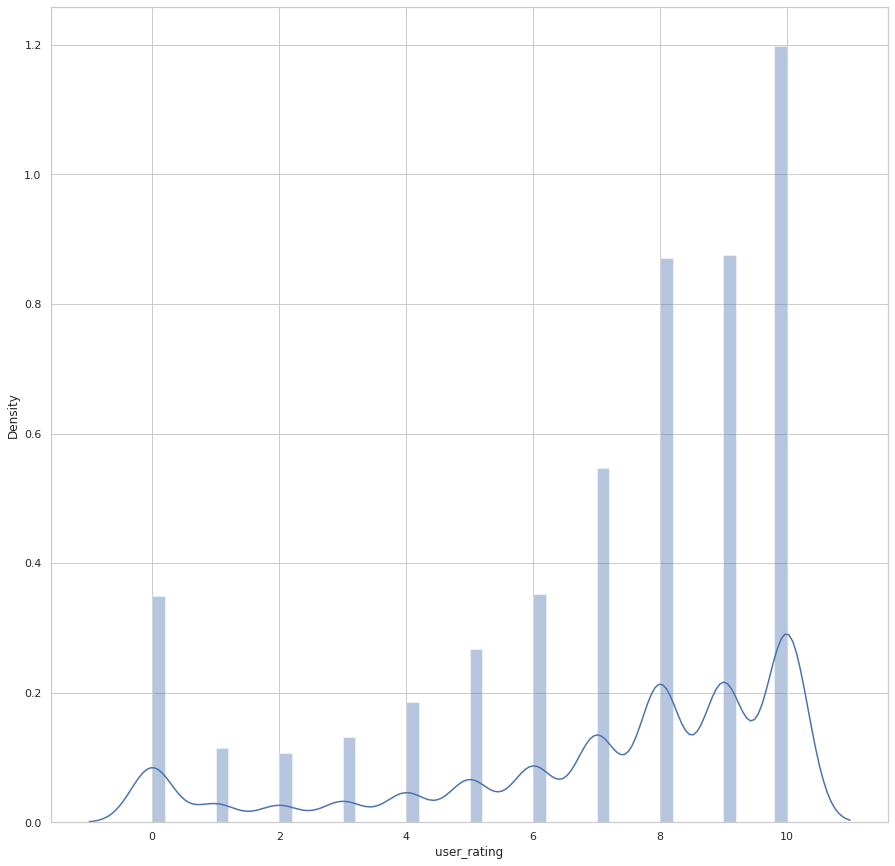

In [10]:
plt.figure(figsize=(15,15))
sns.distplot(df_games['user_rating'])

From the ratings plot we can see than more users do rate games the in the range of 8-10 , with 10 having the highest probability distribution from the distplot above.

<AxesSubplot:xlabel='user_rating'>

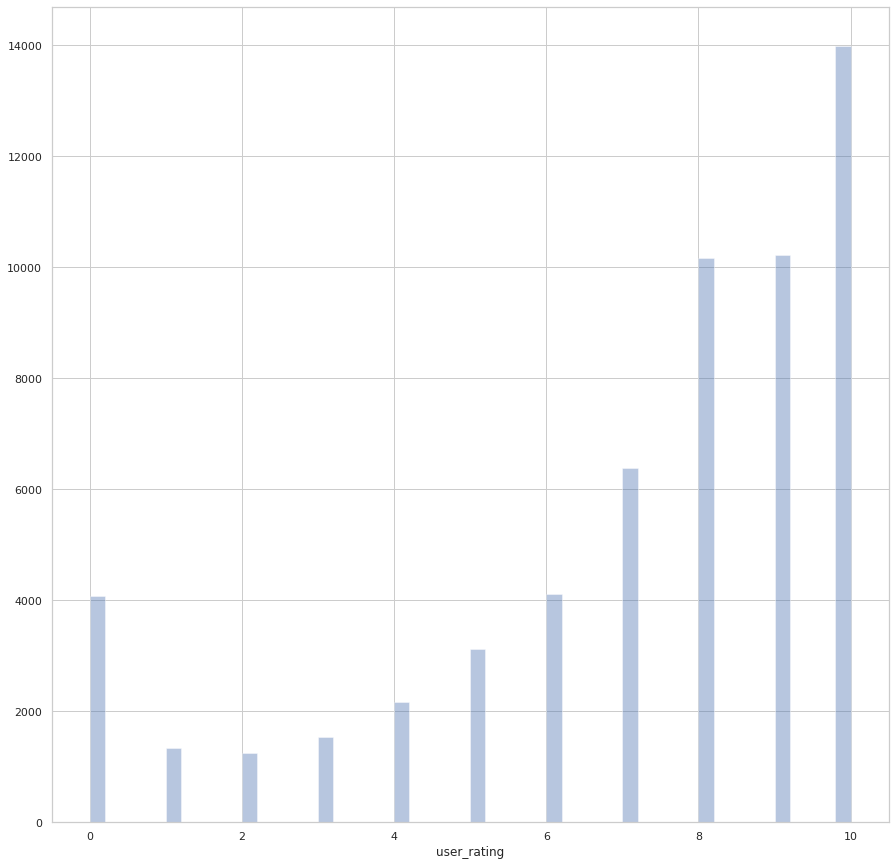

In [11]:
plt.figure(figsize=(15,15))
sns.distplot(df_games['user_rating'], kde=False)

The above plot gives a numerical value of number of ratings for games, we see that for ratings betweeen 8-10 more than 34000 ratings which is about 58% of our data.

Rating counts based by games

In [12]:
#grouping games on ratings
df_groupby_game_Ratings = df_games.groupby('Game_name')['user_rating']
#doing the unique count
df_groupby_game_Ratings.count().unique()

ratings_games = pd.DataFrame(df_groupby_game_Ratings.count())
ratings_games.rename(columns={"user_rating": "rating_counts"}, inplace=True)

In [13]:
ratings_games.sort_values(by='rating_counts',ascending=False)[:20]

,rating_counts
Game_name,
The Last of Us Part II,1965
God of War,1202
The Last of Us Remastered,1059
Ghost of Tsushima,1053
Fallout 4,1030
Red Dead Redemption 2,984
Uncharted 4: A Thief's End,962
Horizon Zero Dawn,959
Bloodborne,792


In [14]:
#to understand the above plot much easier we can clip it in such a way that games above 100 can be counted as one category

#grouping games on ratings
df_groupby_game_Ratings = df_games.groupby('Game_name')['user_rating']
#doing the unique count
df_groupby_game_Ratings.count().clip(upper=100).unique()

ratings_games = pd.DataFrame(df_groupby_game_Ratings.count().clip(upper=100))
ratings_games.rename(columns={"user_rating": "rating_counts"}, inplace=True)

<AxesSubplot:xlabel='rating_counts'>

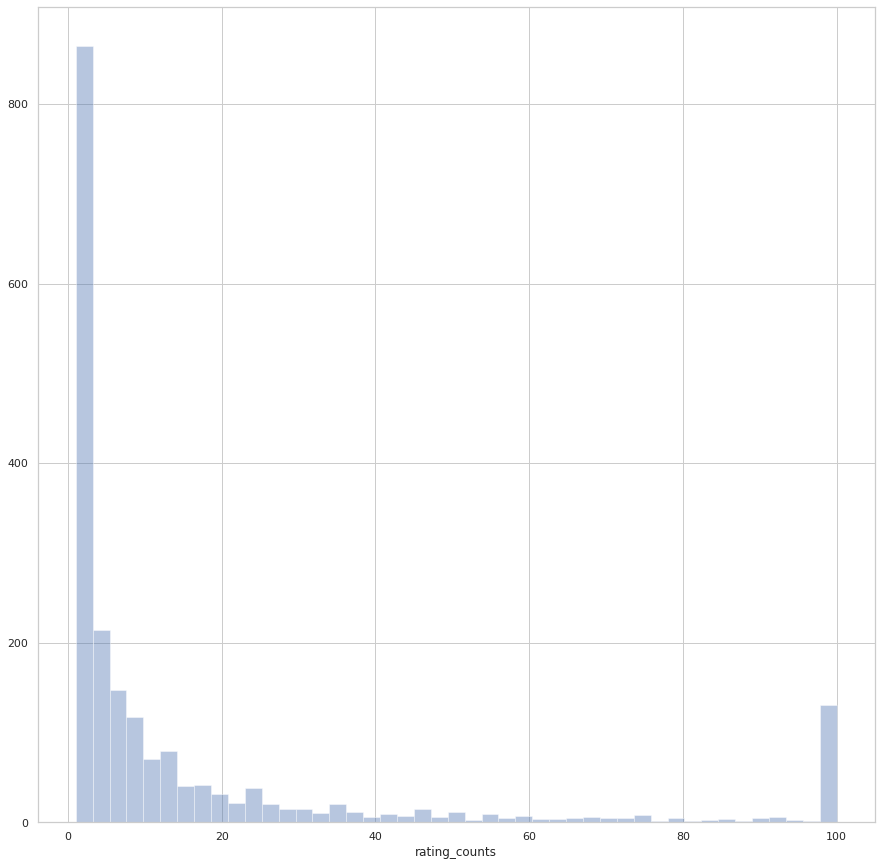

In [15]:
#Plot for number of times games were rated how many times
plt.figure(figsize=(15,15))
sns.distplot(ratings_games['rating_counts'], kde=False)

From the above we can see from the above an overwhelming number of games were only rated once. Quite a few games were rated 100 or more times as well.

Game Rating Counts grouped by Users

In [16]:
#grouping games on ratings
df_groupby_user_Ratings = df_games.groupby('Users')['user_rating']
#doing the unique count
df_groupby_user_Ratings.count().unique()

ratings_user = pd.DataFrame(df_groupby_user_Ratings.count())
ratings_user.rename(columns={"user_rating": "rating_counts"}, inplace=True)

In [17]:
ratings_user.sort_values(by='rating_counts',ascending=False)[:20]

,rating_counts
Users,
/user/SuperkenGaming,390
/user/Nel,209
/user/drlowdon,171
/user/Steyraus,163
/user/SplitMind,127
/user/CoreGamer1408,126
/user/njja02,122
/user/KayVen17,118
/user/wesker2012,106


In [18]:
#to understand the above plot much easier we can clip it in such a way that games above 100 can be counted as one category
#grouping games on ratings
df_groupby_user_Ratings = df_games.groupby('Users')['user_rating']
#doing the unique count
df_groupby_user_Ratings.count().clip(upper=100).unique()

ratings_user = pd.DataFrame(df_groupby_user_Ratings.count()).clip(upper=100)
ratings_user.rename(columns={"user_rating": "rating_counts"}, inplace=True)

<AxesSubplot:xlabel='rating_counts'>

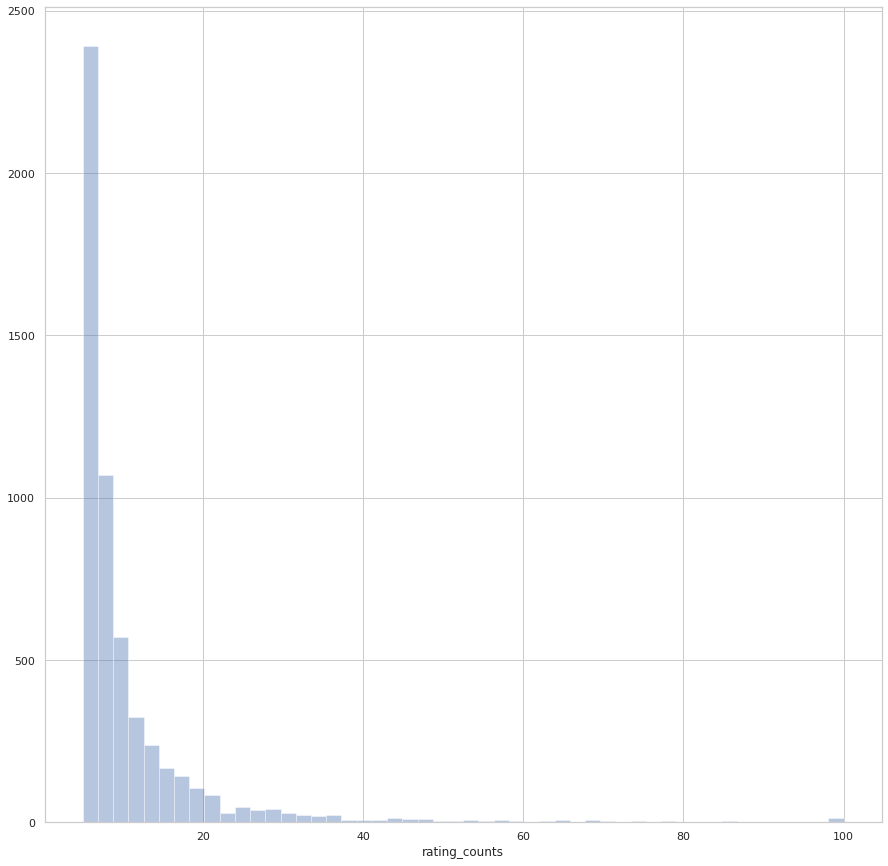

In [19]:
plt.figure(figsize=(15,15))
sns.distplot(ratings_user['rating_counts'],kde=False)

As we can from this plot, most users have 4 reviews, and decreases as the rating counts increases. 
The dataframe also gives details on users ratings counts in descending order.

Mean Rating Distribution grouped by Games

In [20]:
ratings = pd.DataFrame(df_games.groupby('Game_name')['user_rating'].mean())
ratings.rename(columns={"user_rating": "rating_mean"}, inplace=True)

<AxesSubplot:xlabel='rating_mean'>

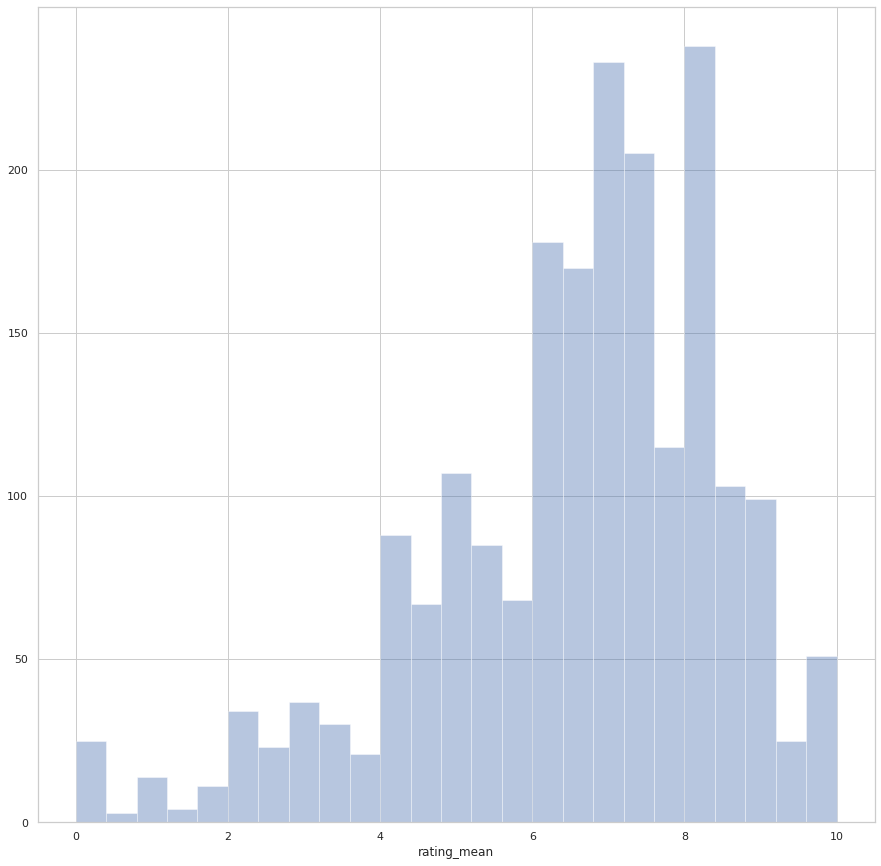

In [21]:
plt.figure(figsize=(15,15))
sns.distplot(ratings['rating_mean'],kde=False)

This is a mean rating distribution grouped by all the games.

As it can been seen from the plot, there are many games which were given a Rating between 6 or 8.

Mean Rating Distribution grouped by Users

<AxesSubplot:xlabel='rating_mean'>

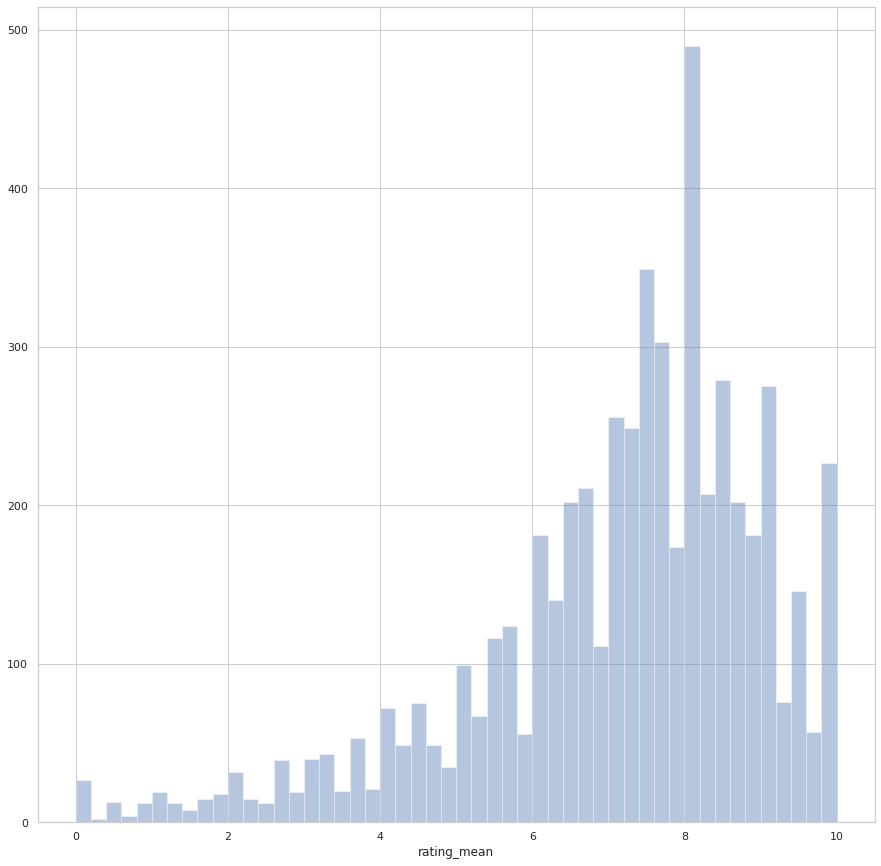

In [22]:
ratings = pd.DataFrame(df_games.groupby('Users')['user_rating'].mean())
ratings.rename(columns={"user_rating": "rating_mean"}, inplace=True)
plt.figure(figsize=(15,15))
sns.distplot(ratings['rating_mean'],kde=False, bins=50)

This is a mean rating distribution grouped by all the Users.

This looks like slightly left skewed normal distribution.

Many users have an average rating of around 8.0-8.2.

Those visualizations gave us a good idea of our data. Lets move onto creating our recommendation system.

# Recommender System

In [23]:
#train test split
train_data, test_data = sk_train_test(df_games, test_size =.20, random_state=10)

In [24]:
#Only selecting users who have given more than 4 game reviews
df1 = df_games['Users'].value_counts().rename_axis('Users').reset_index(name='counts')
#df1 = df1[df1['counts'] > 10]
df_test = df.merge(df1,how='inner', on ='Users') 

In [25]:
#Creating a matrix with users in the rows and game_name as the columns

matrix = df_test.pivot_table(columns='Game_name', index='Users', values='user_rating', fill_value=0)

In [26]:
#function to centre all values in the matrix

def center(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row
matrix_std = matrix.apply(center)

In [27]:
#Function to show the recommendations based for input game based and pearson correlation. (similarity scores)

def gameRec(g):
    dota = matrix_std[g]
#Calculate Pearson Sim with all other games.
    dota = matrix.corrwith(dota).dropna()
#create a DF to show how many times each game has been played and the mean time it has been played
    gameData = df_test.groupby('Game_name').agg({'user_rating': [np.size, np.mean]})
#Filter out any game played by less than n players.
    gameSim = gameData['user_rating']['size'] >= 0
    df = gameData[gameSim].join(pd.DataFrame(dota, columns=['similarity'])).reset_index()
    index = df.index
    entered_game = df["Game_name"] == g
    game_index = index[entered_game]
    df = df.drop(index=game_index)
    return df.sort_values(['similarity'], ascending=False)[:20]

In [28]:
gameRec("Call of Duty: Modern Warfare")

,Game_name,"(user_rating, size)","(user_rating, mean)",similarity
242,Call of Duty: Warzone,50,5.000000,0.188313
225,Call of Duty: Black Ops Cold War,75,3.813333,0.125690
224,Call of Duty: Black Ops 4,113,3.619469,0.114070
237,Call of Duty: Modern Warfare 2 Campaign Remast...,32,7.062500,0.109102
1582,Sword Art Online: Alicization Lycoris,6,6.166667,0.108090
538,FIFA 20,146,2.164384,0.106987
238,Call of Duty: Modern Warfare Remastered,72,6.930556,0.102941
868,Life is Strange 2: Episode 1 - Roads,4,4.250000,0.102311
1404,Senran Kagura: Peach Beach Splash,8,7.500000,0.102004
151,Battlefield V,183,3.748634,0.096890


In [29]:
#returns similarity scores for a given inpuut game. Will be used for multiple game input function
def gameRec_modified(g):
    dota = matrix_std[g]
#Calculate Pearson Sim with all other games.
    dota = matrix.corrwith(dota).dropna()
#create a DF to show how many times each game has been played and the mean time it has been played
    gameData = df_test.groupby('Game_name').agg({'user_rating': [np.size, np.mean]})
#Filter out any game played by less than n players.
    gameSim = gameData['user_rating']['size'] >= 0
    df = gameData[gameSim].join(pd.DataFrame(dota, columns=['similarity']))
    return df['similarity']

In [30]:
#multiple games recommendation - function to recommend based on multiple input games.
x = list(matrix.keys())
df_4 = pd.DataFrame(x , columns= ["Game_name"])
index_list = []
def multi_game(game_list):
    df_4['Total_similarity'] = 0
    #loop based on number of games entered
    for i in game_list:
        new_col = list(gameRec_modified(i))
        df_4[i] = new_col
        df_4['Total_similarity'] = df_4['Total_similarity'] + df_4[i]
    #average of similarity by number of games.
    df_4['Total_similarity'] = df_4['Total_similarity']/len(game_list)
    
    return df_4[['Game_name','Total_similarity']].sort_values(['Total_similarity'], ascending=False)[len(game_list):20] # to reomve games entered as input

In [31]:
multi_game(['inFamous: Second Son','FIFA 15',"Far Cry 4"])

,Game_name,Total_similarity
1946,Watch Dogs,0.201115
2031,inFamous: First Light,0.159075
223,Call of Duty: Advanced Warfare,0.150261
969,Middle-earth: Shadow of Mordor,0.149869
816,Killzone: Shadow Fall,0.145163
892,LittleBigPlanet 3,0.129813
397,Destiny,0.128376
1166,Outlast,0.122683
1970,Wolfenstein: The New Order,0.122131
91,Assassin's Creed IV: Black Flag,0.121612


In [32]:
#multiple games recommendation with rating input
x = list(matrix.keys())
df_4 = pd.DataFrame(x , columns= ["Game_name"])

def multi_game(game_dict):
    df_4['Total_similarity'] = 0
    games = []
    rating_sum = 0
    
    for key in game_dict:
        #condition when only in game is input with rating
        if len(game_dict.keys())==1:
            if game_dict.get(key)==0:
                new_col = list(gameRec_modified(key))
                df_4[key] = new_col
                df_4['Total_similarity'] = df_4['Total_similarity'] + df_4[key]
                print(df_4[['Game_name','Total_similarity']])
                return df_4[['Game_name','Total_similarity']].sort_values(['Total_similarity'], ascending=True)[0:20]
            else:
                new_col = list(gameRec_modified(key))
                df_4[key] = new_col
                df_4['Total_similarity'] = df_4['Total_similarity'] + df_4[key]
                df_5 = df_4[df_4["Game_name"] != key]
                max_val = df_5['Total_similarity'].max()
                min_val = df_5['Total_similarity'].min()
                #print(max_val, min_val)
                adder=(max_val - min_val)/10
                max_range = min_val + adder*game_dict.get(key)
                df_out = df_5.loc[df_5['Total_similarity']<= max_range]
                return df_out[['Game_name','Total_similarity']].sort_values(['Total_similarity'], ascending=False)[0:20]
        else:
            new_col = list(gameRec_modified(key))
            df_4[key] = new_col
            df_4[key] = df_4[key]*((0.1)*game_dict.get(key))
            df_4['Total_similarity'] = df_4['Total_similarity'] + df_4[key]
            games.append(key)
            rating_sum+= game_dict.get(key)
            print(rating_sum)

    df_4['Total_similarity'] = df_4['Total_similarity']/len(game_dict)
    df_5 = df_4[~df_4["Game_name"].isin(games)]
    #if rating_sum==0:
    #    return df_5[['Game_name','Total_similarity']].sort_values(['Total_similarity'], ascending=True)[0:20]
    max_val = df_5['Total_similarity'].max()
    min_val = df_5['Total_similarity'].min()
    adder=(max_val - min_val)/10
    max_range = min_val + adder*(math.ceil(rating_sum/len(games)))
    df_6 = df_5.loc[df_5['Total_similarity']<= max_range]

    return df_6[['Game_name','Total_similarity']].sort_values(['Total_similarity'], ascending=False)[0:20]

In [33]:
multi_game({"FIFA 15":7,"FIFA 19":9})
#a = {'FIFA 15':0}
#a.get('FIFA 15')

7
16


,Game_name,Total_similarity
538,FIFA 20,0.144275
1049,NBA 2K21,0.115267
534,FIFA 16,0.099103
532,FIFA 14,0.099087
798,Just Dance 2019,0.097377
958,Megaton Rainfall,0.091038
831,Knowledge is Power: Decades,0.086438
1041,NBA 2K Playgrounds 2,0.082655
1240,Prison Architect,0.068027
1642,The Bunker,0.067906


The above are recommendation systems that use pearson correlation to recommend games, lets use the suprise library to check other type of models

### Using the Suprise library for recommendation

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. We will try a couple of models from this library.

In [34]:
#encoding the users and the game names as well
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_games['Game_name']= label_encoder.fit_transform(df_games['Game_name'])
df_games['Users']= label_encoder.fit_transform(df_games['Users']) 
df_games.head()

,Users,Game_name,user_rating
4,3957,1289,7
5,5268,1289,7
6,3997,1289,7
8,4939,1289,8
10,4427,1289,5


In [36]:
#creating reader object to read dataframe
reader = Reader(rating_scale =(0,10))
data = Dataset.load_from_df(df_games[['Users', 'Game_name', 'user_rating']], reader)


algo = [SVD(), KNNBasic(), KNNWithMeans(), SVDpp(), KNNWithZScore()]
names = ['SVD', 'KNNBasic', 'KNNWithMeans', 'SVDpp', 'KNNWithZScore']
accuracy_list = []

#train test split using suprise
trainset, testset = train_test_split(data, test_size=.2,random_state=42)

#Loop to train models
for model in range(len(algo)):
    print( names[model] +' model')
    algo[model].fit(trainset)
    predictions = algo[model].test(testset)
    x = accuracy.rmse(predictions)
    accuracy_list.append(x)

SVD model
RMSE: 2.3795
KNNBasic model
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.5246
KNNWithMeans model
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.4681
SVDpp model
RMSE: 2.4003
KNNWithZScore model
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.5184


In [37]:
#dataframe to check rmse for each model.
performance_df = pd.DataFrame(names, columns=['Algorithm'])
performance_df['test_rmse'] = accuracy_list
performance_df

,Algorithm,test_rmse
0,SVD,2.379476
1,KNNBasic,2.524618
2,KNNWithMeans,2.468078
3,SVDpp,2.400297
4,KNNWithZScore,2.518387


From the above models we can see that the SVD model has the least RMSE and hence performs the best.

In [38]:
#Using cross validation to see if we can improve performance
cross_val = []
for model in range(len(algo)):
    x = cross_validate(algo[model],data,cv=5,return_train_measures=True)
    cross_val.append(x['test_rmse'].mean())

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [39]:
performance_df['test_rsme_cv'] = cross_val
performance_df

,Algorithm,test_rmse,test_rsme_cv
0,SVD,2.379476,2.366617
1,KNNBasic,2.524618,2.528661
2,KNNWithMeans,2.468078,2.465234
3,SVDpp,2.400297,2.419676
4,KNNWithZScore,2.518387,2.500672


We see that cross-validating does not make much of a difference.

In [40]:
algo = [SVD, KNNBasic, KNNWithMeans, SVDpp, KNNWithZScore]
param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

for i in algo:
    gs = GridSearchCV(i, param_grid, measures=['rmse'], cv=3)
    gs.fit(data)
    params = gs.best_params['rmse']
#svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

    print(gs.best_score)
    print(gs.best_params)
    print(gs.best_estimator)
    

{'rmse': 2.3714387281067038}
{'rmse': {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f00ecca1150>}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix

The gridsearchCV did not make any difference either and we conclude that the cross-validation SVD model was the best RMSE based model.